This notebook covers the following steps of the data wrangling (cleaning) process:
- Restructuring the Data
    - Data Conversion (DICOM to NIfTI)
    - Resampling to ISOTROPIC pixel spacing
    - Resampling to same dimension
- Identifying and removing Missing Values
- Removing Non-Relevant Data

In [44]:
import os
import shutil
import subprocess
import pandas as pd
from loguru import logger
from brain_tumor_segmentation.config import (
    PROCESSED_DATA_DIR,
    PROCESSED_METADATA_DIR,
    BRATS_2021_DICOMDIR,
    BRATS_2021_NIfTI_DIR
)

# Load site metadata into pandas DataFrame
file_path = os.path.join(PROCESSED_METADATA_DIR, 'study_dicom_metadata.csv')
df = pd.read_csv(file_path, converters={'PatientID': str})
df['PatientID'] = df['PatientID'].astype(str).str.zfill(5)

# Load aggregate site metadata into pandas DataFrame
agg_file_path = os.path.join(PROCESSED_METADATA_DIR, 'study_agg_dicom_metadata.csv')
df_agg = pd.read_csv(agg_file_path, converters={'PatientID': str})
df_agg['PatientID'] = df_agg['PatientID'].astype(str).str.zfill(5)

# Group by PatientID, ScanType, and Site
grouped_df = df.groupby(['PatientID', 'ScanType', 'Site'])['DCMFileName'].apply(list).reset_index()

# Define output root directory
output_root = os.path.join(PROCESSED_DATA_DIR, "NIfTI")
os.makedirs(output_root, exist_ok=True)

# Store information about participants that tdo not have labels/segmentation
skip_list = {}

In [45]:
def process_patient(row):
    """Processes a single patient's DICOM to NIfTI conversion and metadata extraction."""
    site = row['Site']
    patient_id = str(row['PatientID'])
    scan_type = row['ScanType']

    # Create output directory where results of DICOM to NIFTI conversion will be stored
    output_dir = os.path.join(output_root, site, patient_id, scan_type)
    os.makedirs(output_dir, exist_ok=True)

    # Convert DICOM to NIfTI if not already done
    nifti_file_path = os.path.join(output_dir, f"{site}_{patient_id}_{scan_type}.nii.gz")
    if not os.path.exists(nifti_file_path):
        source_dicom_dir = os.path.join(BRATS_2021_DICOMDIR, site, patient_id, scan_type)
        
        # Run dcm2niix via system command
        command = f"dcm2niix -o {output_dir} -w 0 -z y {source_dicom_dir}"
        subprocess.run(
            command, 
            shell=True,
            stdout=subprocess.DEVNULL,
            stderr=subprocess.STDOUT
        )

        # Retrieve file paths
        result_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir)]
        old_nifti_file = next((f for f in result_files if f.endswith('.nii.gz')), None)
        old_json_file = next((f for f in result_files if f.endswith('.json')), None)

        # Rename files if they exist
        if old_nifti_file:
            os.rename(old_nifti_file, nifti_file_path)
        if old_json_file:
            new_json_file = os.path.join(output_dir, f"{site}_{patient_id}_{scan_type}.json")
            os.rename(old_json_file, new_json_file)

    # Copy Segmentation file - Segmentation Files DID NOT come in DICOM, but rather in NIfTI format
    # so all we need to do is copy them over
    seg_file = os.path.join(BRATS_2021_NIfTI_DIR, site, f'BraTS2021_{patient_id}', f'BraTS2021_{patient_id}_seg.nii.gz')
    new_seg_file = os.path.join(output_root, site, patient_id, f"{site}_{patient_id}_segmentation.nii.gz")
    
    # If file has not already been copied, copy it. Or, if file does not exist, store that information in a dict
    if os.path.exists(seg_file) and not os.path.exists(new_seg_file):
        shutil.copy(seg_file, new_seg_file)
    elif not os.path.exists(seg_file):
        #logger.warning(f"Missing segmentation for {site} | {patient_id} | {scan_type}")
        try:
            skip_list[site].append(patient_id)
        except KeyError:
            skip_list[site] = [patient_id]
            
    # Extract metadata for corresponding NIfTI file
    metadata_file = os.path.join(output_dir, f"{site}_{patient_id}_{scan_type}_metadata.csv")
    if not os.path.exists(metadata_file):
        metadata_columns = ["Mean_Intensity", "Std_Intensity", "Mean_Entropy", "Mean_GLCM_Contrast", "Mean_GLCM_Correlation", "Mean_GLCM_Energy", "Mean_GLCM_Homogeneity"]
        metadata_df = df_agg[(df_agg['Site'] == site) & (df_agg['PatientID'] == patient_id) & (df_agg['ScanType'] == scan_type)][metadata_columns]
        metadata_df.to_csv(metadata_file, index=False)

    print(f"Completed {site} | {patient_id} | {scan_type}")

In [46]:
from concurrent.futures import ThreadPoolExecutor

# Use ThreadPoolExecutor to process patients in parallel
with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    executor.map(process_patient, [row for _, row in grouped_df.iterrows()])

print("Conversion and metadata extraction completed!")

Completed UCSF-PDGM | 00000 | FLAIR
Completed UCSF-PDGM | 00000 | T1w
Completed UCSF-PDGM | 00000 | T2w
Completed UCSF-PDGM | 00000 | T1wCE
Completed UCSF-PDGM | 00001 | FLAIR
Completed UCSF-PDGM | 00001 | T1wCE
Completed UCSF-PDGM | 00001 | T1w
Completed UCSF-PDGM | 00002 | T1wCE
Completed UCSF-PDGM | 00001 | T2w
Completed UCSF-PDGM | 00002 | FLAIR
Completed UCSF-PDGM | 00002 | T2w
Completed UCSF-PDGM | 00003 | T1wCE
Completed UCSF-PDGM | 00002 | T1w
Completed UCSF-PDGM | 00005 | FLAIR
Completed UCSF-PDGM | 00003 | T1w
Completed UCSF-PDGM | 00003 | T2w
Completed UCSF-PDGM | 00003 | FLAIR
Completed UCSF-PDGM | 00005 | T1wCE
Completed UCSF-PDGM | 00006 | T1w
Completed UCSF-PDGM | 00005 | T2w
Completed UCSF-PDGM | 00009 | FLAIR
Completed UCSF-PDGM | 00008 | T1wCE
Completed UCSF-PDGM | 00006 | T1wCE
Completed UCSF-PDGM | 00005 | T1w
Completed UCSF-PDGM | 00006 | FLAIR
Completed UCSF-PDGM | 00006 | T2w
Completed UCSF-PDGM | 00008 | T1w
Completed UCSF-PDGM | 00008 | T2w
Completed UCSF-PDGM 

In [47]:
# Print out all of the subjects that do not have segmentation/lable file
for site in skip_list:
    logger.warning(f"For Site '{site}' there are total {len(skip_list[site])} labels missing")

2025-02-16 11:21:09.271 | WARNING  | __main__:<module>:3 - For Site 'UCSF-PDGM' there are total 144 labels missing
2025-02-16 11:21:09.271 | WARNING  | __main__:<module>:3 - For Site 'TCGA-GBM' there are total 28 labels missing
2025-02-16 11:21:09.271 | WARNING  | __main__:<module>:3 - For Site 'UPENN-GBM' there are total 113 labels missing
2025-02-16 11:21:09.271 | WARNING  | __main__:<module>:3 - For Site 'new-not-previously-in-TCIA' there are total 56 labels missing
2025-02-16 11:21:09.271 | WARNING  | __main__:<module>:3 - For Site 'CPTAC-GBM' there are total 12 labels missing
2025-02-16 11:21:09.271 | WARNING  | __main__:<module>:3 - For Site 'IvyGAP' there are total 16 labels missing


In [48]:
skip_list

{'UCSF-PDGM': ['00001',
  '00001',
  '00001',
  '00001',
  '00013',
  '00015',
  '00013',
  '00013',
  '00015',
  '00015',
  '00013',
  '00015',
  '00027',
  '00027',
  '00027',
  '00027',
  '00037',
  '00037',
  '00037',
  '00037',
  '00047',
  '00047',
  '00047',
  '00047',
  '00079',
  '00079',
  '00079',
  '00079',
  '00080',
  '00080',
  '00082',
  '00082',
  '00082',
  '00080',
  '00082',
  '00080',
  '00091',
  '00091',
  '00091',
  '00091',
  '00462',
  '00463',
  '00462',
  '00462',
  '00463',
  '00462',
  '00463',
  '00467',
  '00467',
  '00467',
  '00467',
  '00463',
  '00474',
  '00474',
  '00474',
  '00474',
  '00489',
  '00489',
  '00489',
  '00492',
  '00489',
  '00492',
  '00492',
  '00492',
  '00503',
  '00503',
  '00503',
  '00503',
  '00521',
  '00521',
  '00521',
  '00521',
  '00535',
  '00535',
  '00535',
  '00535',
  '00553',
  '00553',
  '00553',
  '00553',
  '00560',
  '00560',
  '00560',
  '00560',
  '00603',
  '00603',
  '00603',
  '00603',
  '00644',
  '00644

In [50]:
# Remove directories without lables
for site in skip_list:
    pids_to_delete = list(set(skip_list[site]))
    for subject in pids_to_delete:
        print(f"Removnig {site} {subject}")
        shutil.rmtree(os.path.join(PROCESSED_DATA_DIR, "NIfTI", site, subject))

Removnig UCSF-PDGM 00560
Removnig UCSF-PDGM 00013
Removnig UCSF-PDGM 00644
Removnig UCSF-PDGM 00082
Removnig UCSF-PDGM 00681
Removnig UCSF-PDGM 00779
Removnig UCSF-PDGM 00037
Removnig UCSF-PDGM 00079
Removnig UCSF-PDGM 00492
Removnig UCSF-PDGM 00769
Removnig UCSF-PDGM 00080
Removnig UCSF-PDGM 00603
Removnig UCSF-PDGM 00762
Removnig UCSF-PDGM 00015
Removnig UCSF-PDGM 00462
Removnig UCSF-PDGM 00535
Removnig UCSF-PDGM 00489
Removnig UCSF-PDGM 00027
Removnig UCSF-PDGM 00712
Removnig UCSF-PDGM 00719
Removnig UCSF-PDGM 00749
Removnig UCSF-PDGM 00463
Removnig UCSF-PDGM 00647
Removnig UCSF-PDGM 00503
Removnig UCSF-PDGM 00721
Removnig UCSF-PDGM 00467
Removnig UCSF-PDGM 00521
Removnig UCSF-PDGM 00671
Removnig UCSF-PDGM 00662
Removnig UCSF-PDGM 00474
Removnig UCSF-PDGM 00553
Removnig UCSF-PDGM 00047
Removnig UCSF-PDGM 00702
Removnig UCSF-PDGM 00091
Removnig UCSF-PDGM 00699
Removnig UCSF-PDGM 00001
Removnig TCGA-GBM 00119
Removnig TCGA-GBM 01006
Removnig TCGA-GBM 00114
Removnig TCGA-GBM 00997
Remo

Now, let's validate our NIfTI files by 1st making sure that ANATOMY and SEGMENTATION images are in same PHYSICAL SPACE and have same ORIENTATION

Images occupy a region in physical space which is defined by:
- Origin.
- Size (number of pixels per dimension).
- Spacing (unknown consistent units: nm, mm, m, km...).
- Direction cosine matrix (axis directions in physical space).

These attributes are the image's meta-data. 

In [9]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from collections import defaultdict

def is_in_same_physical_space(image_1_path, image_2_path) -> bool:
    """
    Checks if provided images are in same physical space
    
    Arguments:
        - image_1_path (str): absolute path to image 1
        - image_2_path (str): absolute path to image 2
    Returns:
        True if provided images are in the same physical space, false otherwise
    """
    # Check if path to images exists
    if not os.path.exists(image_1_path):
        raise FileNotFoundError(f"{image_1_path} does not exist")
    elif not os.path.exists(image_2_path):
        raise FileNotFoundError(f"{image_2_path} does not exist")
    
    # Load images
    sitk_img1 = sitk.ReadImage(image_1_path)
    sitk_img2 = sitk.ReadImage(image_2_path)
    
    # Get image 1 information
    sitk_img1_origin = sitk_img1.GetOrigin()
    sitk_img1_size = sitk_img1.GetSize()
    sitk_img1_direction = sitk_img1.GetDirection()
    
    # Get image 2 information
    sitk_img2_origin = sitk_img2.GetOrigin()
    sitk_img2_size = sitk_img2.GetSize()
    sitk_img2_direction = sitk_img2.GetDirection()
    
    print(sitk_img1_origin, sitk_img2_origin)
    print(sitk_img1_direction, sitk_img2_direction)
    print(sitk_img1_size, sitk_img2_size)
    # Check if images are in same physical space
    if sitk_img1_origin == sitk_img2_origin and \
       sitk_img1_direction == sitk_img2_direction and \
       sitk_img1_size == sitk_img2_size:
        return True           
    return False

def get_nifti_dimensions(root_dir, substring=''):
    """
    Scans the dataset directory structure and retrieves the dimensions of NIfTI images for each modality and segmentation.
    :param root_dir: Path to the root directory containing subject directories.
    :return: Dictionary with modality and segmentation as keys and list of (x, y, z) dimensions as values.
    """
    modalities = ['FLAIR', 'T1W', 'T1wCE', 'T2w']
    dimensions = {modality: [] for modality in modalities}
    dimensions['Segmentation'] = []
    
    for subject in os.listdir(root_dir):
        subject_path = os.path.join(root_dir, subject)
        if not os.path.isdir(subject_path):
            continue
        
        for modality in modalities:
            modality_path = os.path.join(subject_path, modality)
            if not os.path.isdir(modality_path):
                continue
            
            for file in os.listdir(modality_path):
                substring = substring if substring != '' else '.nii.gz'
                if file.endswith(substring):
                    file_path = os.path.join(modality_path, file)
                    image = sitk.ReadImage(file_path)
                    dimensions[modality].append(image.GetSize())
        try:
            seg_path = [os.path.join(subject_path, f) for f in os.listdir(subject_path) if f.endswith("segmentation.nii.gz")][0]
            image = sitk.ReadImage(seg_path)
            dimensions['Segmentation'].append(image.GetSize())
        except IndexError:
            # this subject does not have segmentation
            pass
    
    return dimensions

def plot_dimension_distribution(dimensions, figsize=(15, 15)):
    """
    Plots the distribution of NIfTI image dimensions for each modality and segmentation with a legend.
    :param dimensions: Dictionary with modality/segmentation as keys and list of (x, y, z) tuples.
    """
    plt.figure(figsize=figsize)
    
    for category, dims in dimensions.items():
        dim_counts = defaultdict(int)
        
        for dim in dims:
            dim_counts[dim] += 1
        
        sorted_dims = sorted(dim_counts.items(), key=lambda x: x[1], reverse=True)
        labels = [str(dim[0]) for dim in sorted_dims]
        counts = [dim[1] for dim in sorted_dims]
        
        plt.barh(labels, counts, label=category, alpha=0.7)
    
    plt.xlabel("Frequency")
    plt.ylabel("Image Dimensions (x, y, z)")
    plt.title("Distribution of NIfTI Image Dimensions for Each Modality and Segmentation")
    plt.legend()
    plt.gca().invert_yaxis()
    plt.show()
    
def print_dimension_statistics(dimensions):
    """
    Prints the statistics of NIfTI image dimensions for each modality and segmentation.
    :param dimensions: Dictionary with modality/segmentation as keys and list of (x, y, z) tuples.
    """
    for category, dims in dimensions.items():
        if not dims:
            continue
        
        x_sizes = [dim[0] for dim in dims]
        y_sizes = [dim[1] for dim in dims]
        z_sizes = [dim[2] for dim in dims]
        
        print(f"Statistics for {category}:")
        print(f"  X dimension - Min: {min(x_sizes)}, Max: {max(x_sizes)}, Mean: {sum(x_sizes) / len(x_sizes):.2f}")
        print(f"  Y dimension - Min: {min(y_sizes)}, Max: {max(y_sizes)}, Mean: {sum(y_sizes) / len(y_sizes):.2f}")
        print(f"  Z dimension - Min: {min(z_sizes)}, Max: {max(z_sizes)}, Mean: {sum(z_sizes) / len(z_sizes):.2f}")
        print("-----------------------------------")

In [10]:
# Define root NIfTI directory
root_dir = os.path.join(PROCESSED_DATA_DIR, "NIfTI")

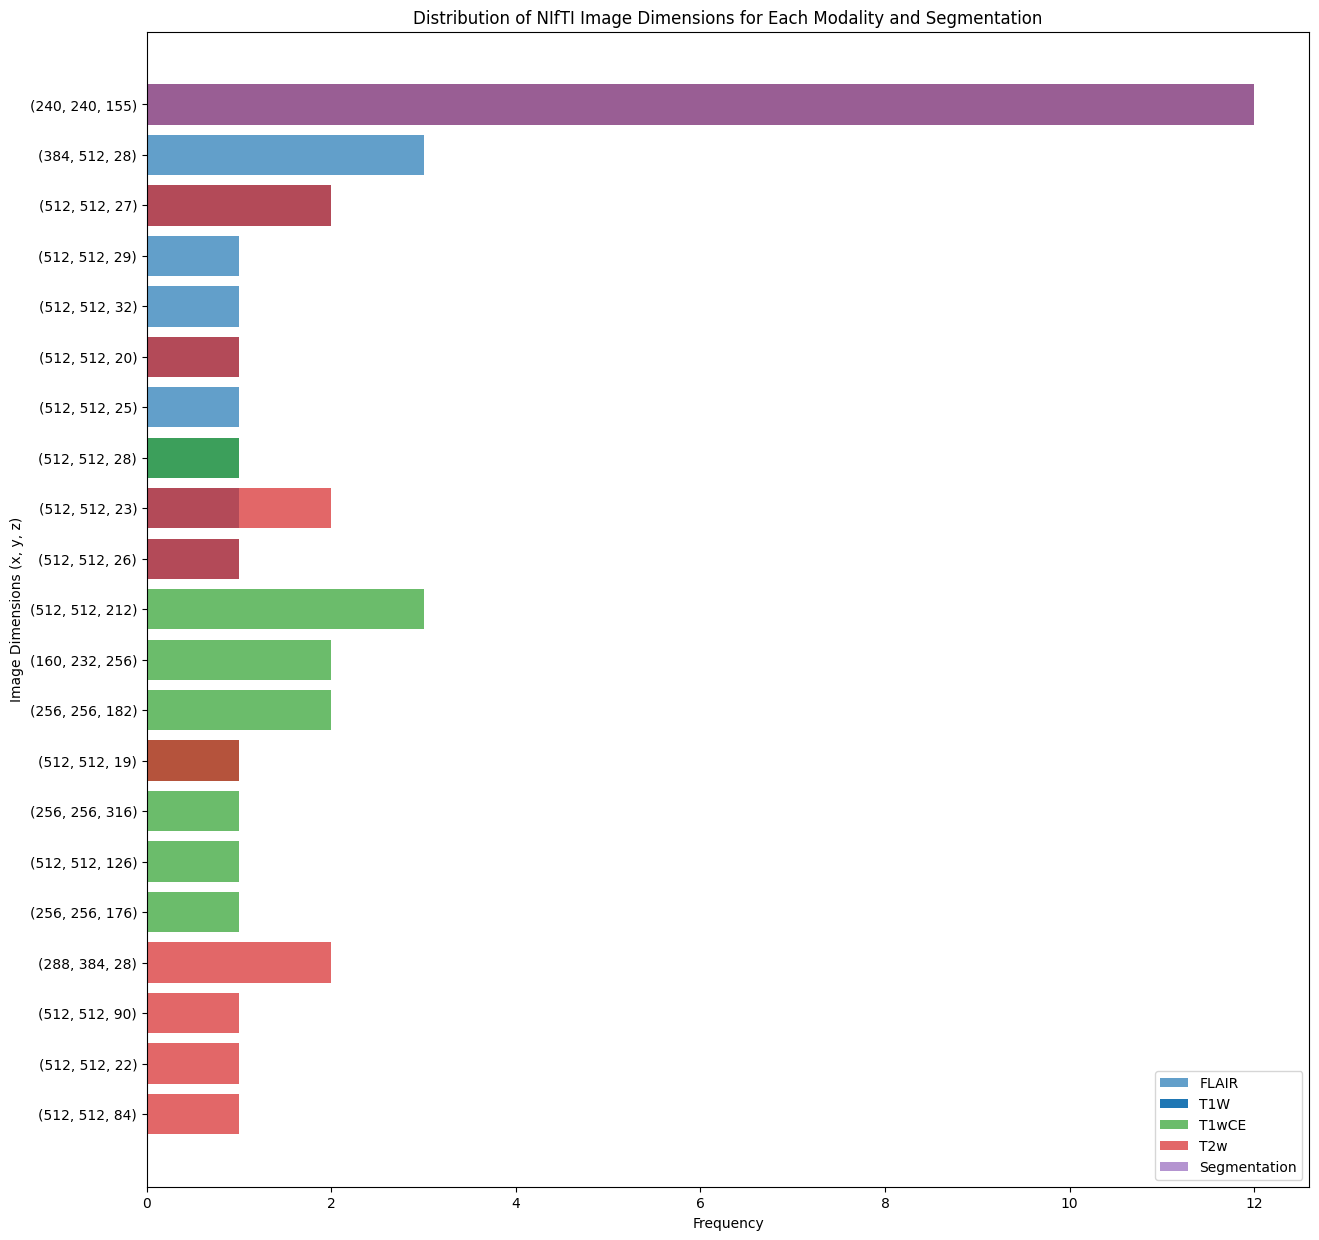

Statistics for FLAIR:
  X dimension - Min: 240, Max: 512, Mean: 360.00
  Y dimension - Min: 240, Max: 512, Mean: 376.00
  Z dimension - Min: 20, Max: 155, Mean: 90.88
-----------------------------------
Statistics for T1wCE:
  X dimension - Min: 160, Max: 512, Mean: 304.00
  Y dimension - Min: 232, Max: 512, Mean: 310.00
  Z dimension - Min: 19, Max: 316, Mean: 168.21
-----------------------------------
Statistics for T2w:
  X dimension - Min: 240, Max: 512, Mean: 357.33
  Y dimension - Min: 240, Max: 512, Mean: 365.33
  Z dimension - Min: 19, Max: 155, Mean: 94.88
-----------------------------------
Statistics for Segmentation:
  X dimension - Min: 240, Max: 240, Mean: 240.00
  Y dimension - Min: 240, Max: 240, Mean: 240.00
  Z dimension - Min: 155, Max: 155, Mean: 155.00
-----------------------------------


In [11]:
# Define path to site directory
CPTAC_GBM_site = os.path.join(root_dir, 'CPTAC-GBM')

# Plot distribution of image dimensions for specific site
dimensions = get_nifti_dimensions(CPTAC_GBM_site)
plot_dimension_distribution(dimensions)

# Print dimension statistics
print_dimension_statistics(dimensions)

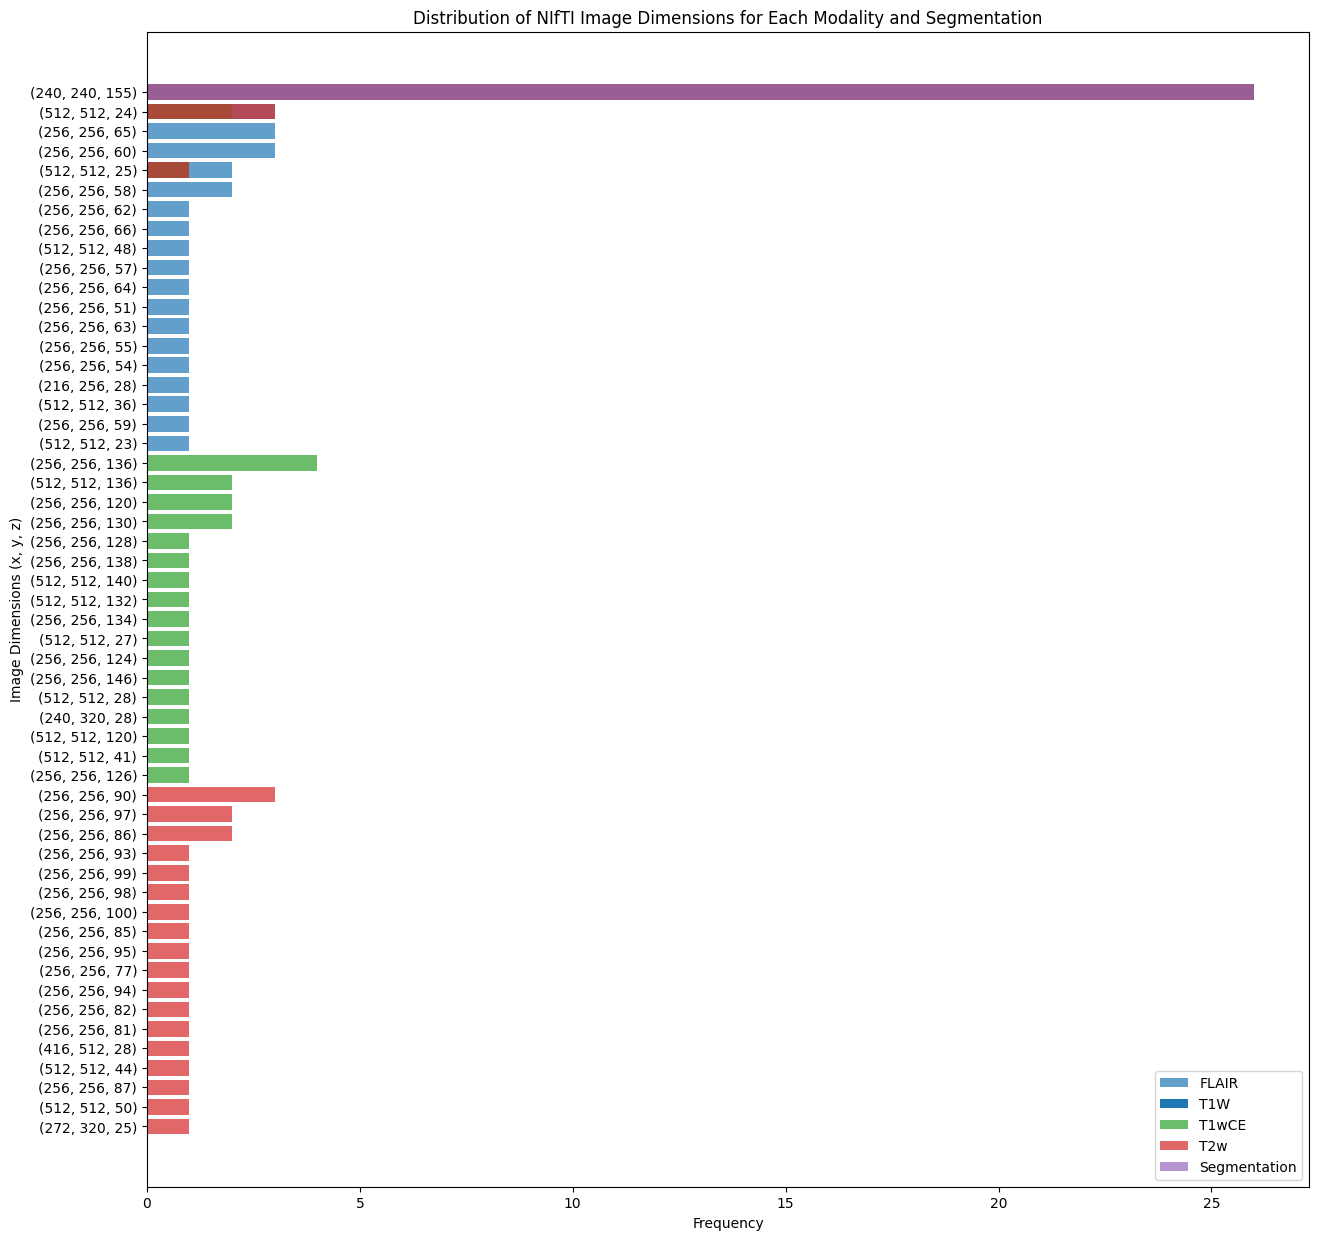

Statistics for FLAIR:
  X dimension - Min: 216, Max: 512, Mean: 286.62
  Y dimension - Min: 240, Max: 512, Mean: 287.38
  Z dimension - Min: 23, Max: 155, Mean: 102.10
-----------------------------------
Statistics for T1wCE:
  X dimension - Min: 240, Max: 512, Mean: 301.85
  Y dimension - Min: 240, Max: 512, Mean: 303.38
  Z dimension - Min: 24, Max: 155, Mean: 129.44
-----------------------------------
Statistics for T2w:
  X dimension - Min: 240, Max: 512, Mean: 280.92
  Y dimension - Min: 240, Max: 512, Mean: 283.69
  Z dimension - Min: 24, Max: 155, Mean: 113.48
-----------------------------------
Statistics for Segmentation:
  X dimension - Min: 240, Max: 240, Mean: 240.00
  Y dimension - Min: 240, Max: 240, Mean: 240.00
  Z dimension - Min: 155, Max: 155, Mean: 155.00
-----------------------------------


In [12]:
# Define path to site directory
IvyGAP_site = os.path.join(root_dir, 'IvyGAP')

# Plot distribution of image dimensions for specific site
dimensions = get_nifti_dimensions(IvyGAP_site)
plot_dimension_distribution(dimensions)

# Print dimension statistics
print_dimension_statistics(dimensions)

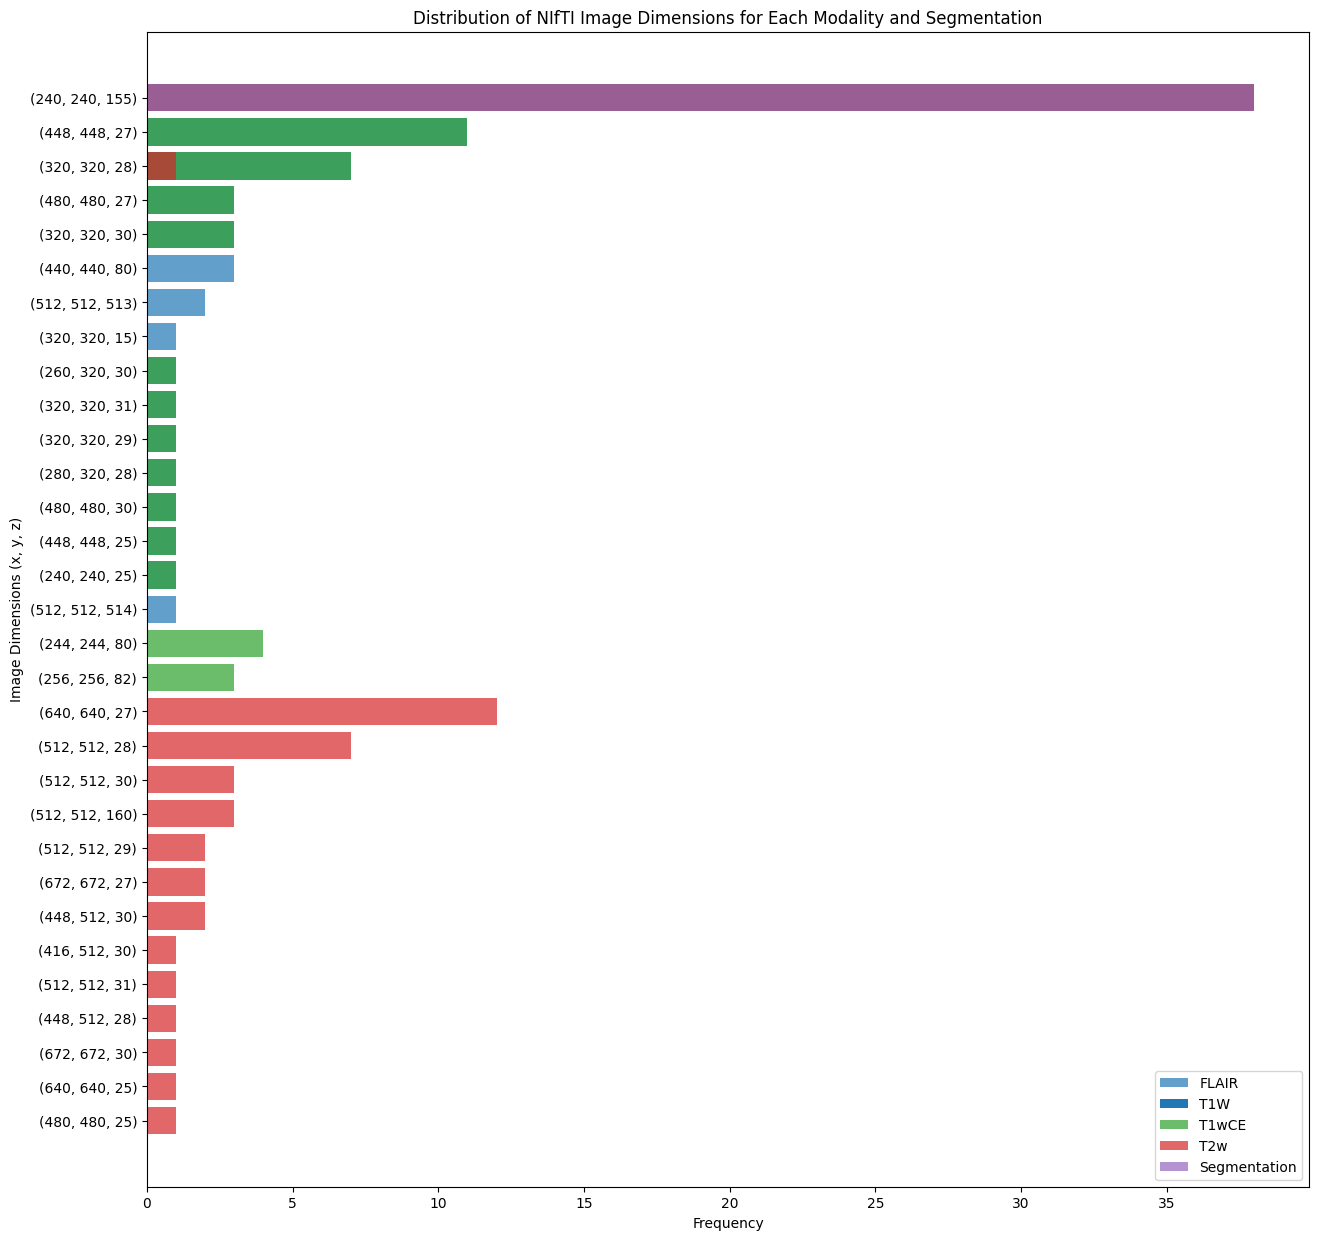

Statistics for FLAIR:
  X dimension - Min: 240, Max: 512, Mean: 318.58
  Y dimension - Min: 240, Max: 512, Mean: 319.89
  Z dimension - Min: 15, Max: 514, Mean: 112.46
-----------------------------------
Statistics for T1wCE:
  X dimension - Min: 240, Max: 480, Mean: 299.74
  Y dimension - Min: 240, Max: 480, Mean: 301.05
  Z dimension - Min: 25, Max: 155, Mean: 96.29
-----------------------------------
Statistics for T2w:
  X dimension - Min: 240, Max: 672, Mean: 397.47
  Y dimension - Min: 240, Max: 672, Mean: 401.26
  Z dimension - Min: 25, Max: 160, Mean: 96.70
-----------------------------------
Statistics for Segmentation:
  X dimension - Min: 240, Max: 240, Mean: 240.00
  Y dimension - Min: 240, Max: 240, Mean: 240.00
  Z dimension - Min: 155, Max: 155, Mean: 155.00
-----------------------------------


In [13]:
# Define path to site directory
new_not_previously_in_TCIA_site = os.path.join(root_dir, 'new-not-previously-in-TCIA')

# Plot distribution of image dimensions for specific site
dimensions = get_nifti_dimensions(new_not_previously_in_TCIA_site)
plot_dimension_distribution(dimensions)

# Print dimension statistics
print_dimension_statistics(dimensions)

In [14]:
def plot_histogram(df, column, bins=20):
    """
    Plots a histogram for a given column in the DataFrame.
    :param df: Pandas DataFrame containing the data.
    :param column: Column name to plot.
    :param bins: Number of bins for the histogram.
    """
    plt.figure(figsize=(8, 5))
    plt.hist(df[column].dropna(), bins=bins, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {column}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_pixel_spacing_distribution(df, bins=20):
    """
    Plots a combined histogram for PixelSpacing_X and PixelSpacing_Y on the same plot.
    :param df: Pandas DataFrame containing the data.
    :param bins: Number of bins for the histogram.
    """
    plt.figure(figsize=(8, 5))
    plt.hist([df["PixelSpacing_X"].dropna(), df["PixelSpacing_Y"].dropna()], bins=bins, alpha=0.5, label=['PixelSpacing_X', 'PixelSpacing_Y'], edgecolor='black', stacked=False)
    plt.xlabel("Pixel Spacing")
    plt.ylabel("Frequency")
    plt.title("Distribution of Pixel Spacing X and Y")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def compute_statistics(df, columns):
    """
    Computes and prints basic statistics for given columns in a DataFrame.
    :param df: Pandas DataFrame containing the data.
    :param columns: List of column names to compute statistics for.
    """
    for column in columns:
        if column in df.columns:
            data = df[column].dropna()
            print(f"Statistics for {column}:")
            print(f"  Mean: {data.mean():.4f}")
            print(f"  Median: {data.median():.4f}")
            print(f"  Std Dev: {data.std():.4f}")
            print(f"  Min: {data.min():.4f}")
            print(f"  Max: {data.max():.4f}")

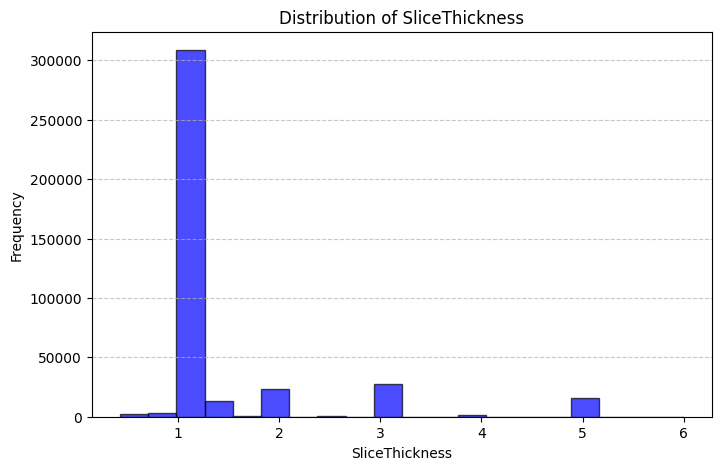

Statistics for SliceThickness:
  Mean: 1.4223
  Median: 1.0000
  Std Dev: 0.9135
  Min: 0.4297
  Max: 6.0000


In [15]:
# Plot Slice Thickness distribution
plot_histogram(df, "SliceThickness")
# Compute summary statistics for Slice Thickness
compute_statistics(df, ["SliceThickness"])

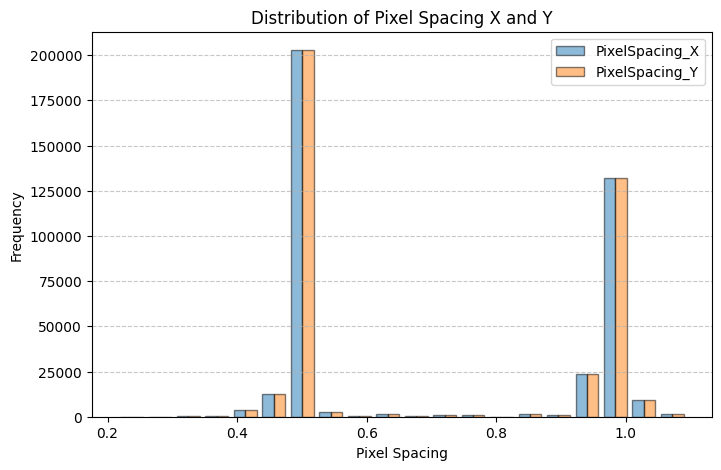

Statistics for PixelSpacing_X:
  Mean: 0.7045
  Median: 0.5000
  Std Dev: 0.2403
  Min: 0.2150
  Max: 1.0938
Statistics for PixelSpacing_Y:
  Mean: 0.7045
  Median: 0.5000
  Std Dev: 0.2403
  Min: 0.2150
  Max: 1.0938


In [16]:
# Plot pixel spacing distribution
plot_pixel_spacing_distribution(df)
# Compute summary statistics for PixelSpacing_X and PixelSpacing_Y
compute_statistics(df, ["PixelSpacing_X", "PixelSpacing_Y"])

Following conclusions can be drawn from the analysis of `image dimensions`, `slice thickness` and `pixel spacing`:
- It seems that for each SITE, all segmentation NIfTI files have dimension of `(240, 240, 155)`, using SimpleITK, we have to RESAMPLE all of the other modalities to before-mentioned dimensions
- Pixel Spacing varies too much, so we have to make sure that all images are resampled to **ISOTROPIC RESOLUTION** `(1mm x 1mm x 1mm)`. Isotropic resolution is important in quantitative analysis, image registration, and segmentation because it ensures that no particular dimension is distorted relative to the others

In [14]:
import SimpleITK as sitk
import numpy as np

def resample_img(itk_image, out_spacing=[1.0, 1.0, 1.0], is_label=False, out_size=None, segmentation=None):   
    """
    Resamples an ITK image to a specified resolution and applies the affine 
    transformation (qform or sform) from a given segmentation image.
    
    Parameters:
    - itk_image (SimpleITK.Image): The input image to be resampled.
    - out_spacing (list of float, optional): The desired output spacing (default: [1.0, 1.0, 1.0] mm).
    - is_label (bool, optional): Whether the image is a label map (default: False). If True, uses nearest-neighbor interpolation.
    - out_size (list of int, optional): Desired output size after resampling. If None, the size is computed based on spacing.
    - segmentation (SimpleITK.Image, optional): A reference segmentation image to copy the QForm/SForm.

    Returns:
    - SimpleITK.Image: The resampled image with the specified spacing, size, and copied transform.
    """
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    # Compute output size if not provided
    if out_size is None:
        out_size = [
            int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
            int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
            int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2]))),
        ]
    
    # Create resampler
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    # Use appropriate interpolation
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    # Resample image
    resampled_img = resample.Execute(itk_image)

    # If a segmentation reference is provided, copy its valid affine transform
    if segmentation:
        seg_origin = segmentation.GetOrigin()
        seg_direction = segmentation.GetDirection()

        # Check if segmentation has a valid transform
        if np.all(np.array(seg_direction) == 0):  # Invalid segmentation SForm (srow_x/y/z are all 0)
            print("WARNING: Segmentation SForm is invalid (srow_x/y/z are zero). Keeping MRI transform unchanged.")
        else:
            # Copy valid transformation from segmentation
            resampled_img.SetDirection(seg_direction)
            resampled_img.SetOrigin(seg_origin)
            resampled_img.SetSpacing(segmentation.GetSpacing())

    return resampled_img


In [15]:
# Sample image
img_path = os.path.join(PROCESSED_DATA_DIR, "NIfTI", "CPTAC-GBM", "00442", "FLAIR", "CPTAC-GBM_00442_FLAIR.nii.gz")
seg_path = os.path.join(PROCESSED_DATA_DIR, "NIfTI", "CPTAC-GBM", "00442",  "CPTAC-GBM_00442_segmentation.nii.gz")

# Load images via SimpleITK
sitk_img = sitk.ReadImage(img_path)
sitk_seg = sitk.ReadImage(seg_path)

print(f"Image Size Before Reasmpling: {sitk_img.GetSize()}")
print(f"Image Pixel Spacing Before Reasmpling: {sitk_img.GetSpacing()}")

Image Size Before Reasmpling: (512, 512, 28)
Image Pixel Spacing Before Reasmpling: (0.46880000829696655, 0.46880000829696655, 5.000069618225098)


In [16]:
# Resample to Match Segmentation Size (240, 240, 155) and make it isotropic (pixel spacing: 1x1x1mm3)
resampled_img = resample_img(sitk_img, segmentation=sitk_seg, out_size=(240, 240, 155))
print(f"Image Size After Reasmpling: {resampled_img.GetSize()}")
print(f"Image Pixel Spacing After Reasmpling: {resampled_img.GetSpacing()}")
sitk.WriteImage(resampled_img, os.path.join(PROCESSED_DATA_DIR, '00442_resampled_flair.nii.gz'))

Image Size After Reasmpling: (240, 240, 155)
Image Pixel Spacing After Reasmpling: (1.0, 1.0, 1.0)


In [18]:
from pathlib import Path

root_nifti = Path(PROCESSED_DATA_DIR) / 'NIfTI'

# Iterate over sites using os.scandir() for faster directory access
for site_entry in os.scandir(root_nifti):
    if not site_entry.is_dir():
        continue
    
    site = site_entry.name
    site_path = Path(site_entry.path)

    # Iterate over subjects
    for sub_entry in os.scandir(site_path):
        if not sub_entry.is_dir():
            continue

        sub = sub_entry.name
        sub_path = Path(sub_entry.path)

        # Load segmentation once per subject
        seg_path = sub_path / f"{site}_{sub}_segmentation.nii.gz"
        if not seg_path.exists():
            continue

        seg_img = sitk.ReadImage(str(seg_path))  # Load segmentation once

        # Resample all exams for the subject
        for exam in ['FLAIR', 'T1w', 'T2w', 'T1wCE']:
            exam_path = sub_path / exam / f'{site}_{sub}_{exam}.nii.gz'
            if not exam_path.exists():
                continue
            
            sitk_exam = sitk.ReadImage(str(exam_path))

            # Define the output filename
            new_file_name = f"{site}_{sub}_{exam}_resampled.nii.gz"
            resampled_image_path = exam_path.parent / new_file_name

            # Resample image
            print(f"Resampling {exam_path.name}")
            #resampled_img = resample_img(sitk_exam, segmentation=seg_img, out_size=(240, 240, 155))
            #sitk.WriteImage(resampled_img, str(resampled_image_path))

            exam = 't1' if exam == 'T1w' else exam
            exam = 't2' if exam == 'T2w' else exam
            exam = 't1ce' if exam == 'T1wCE' else exam
            
            path = BRATS_2021_NIfTI_DIR / f'{site}' / f'BraTS2021_{sub}' / f'BraTS2021_{sub}_{exam.lower()}.nii.gz'
            shutil.copy(path, resampled_image_path)            

Resampling UPENN-GBM_00370_FLAIR.nii.gz
Resampling UPENN-GBM_00370_T1w.nii.gz
Resampling UPENN-GBM_00370_T2w.nii.gz
Resampling UPENN-GBM_00370_T1wCE.nii.gz
Resampling UPENN-GBM_00310_FLAIR.nii.gz
Resampling UPENN-GBM_00310_T1w.nii.gz
Resampling UPENN-GBM_00310_T2w.nii.gz
Resampling UPENN-GBM_00310_T1wCE.nii.gz
Resampling UPENN-GBM_00165_FLAIR.nii.gz
Resampling UPENN-GBM_00165_T1w.nii.gz
Resampling UPENN-GBM_00165_T2w.nii.gz
Resampling UPENN-GBM_00165_T1wCE.nii.gz
Resampling UPENN-GBM_00320_FLAIR.nii.gz
Resampling UPENN-GBM_00320_T1w.nii.gz
Resampling UPENN-GBM_00320_T2w.nii.gz
Resampling UPENN-GBM_00320_T1wCE.nii.gz
Resampling UPENN-GBM_00317_FLAIR.nii.gz
Resampling UPENN-GBM_00317_T1w.nii.gz
Resampling UPENN-GBM_00317_T2w.nii.gz
Resampling UPENN-GBM_00317_T1wCE.nii.gz
Resampling UPENN-GBM_01000_FLAIR.nii.gz
Resampling UPENN-GBM_01000_T1w.nii.gz
Resampling UPENN-GBM_01000_T2w.nii.gz
Resampling UPENN-GBM_01000_T1wCE.nii.gz
Resampling UPENN-GBM_01010_FLAIR.nii.gz
Resampling UPENN-GBM_010

After resampling, let's plot dimension distribution again, as well as pixel spacing, to make sure that we've covered every single case

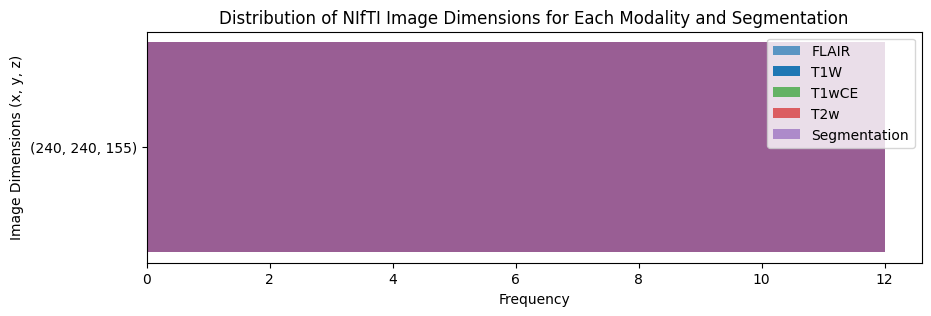

Statistics for FLAIR:
  X dimension - Min: 240, Max: 240, Mean: 240.00
  Y dimension - Min: 240, Max: 240, Mean: 240.00
  Z dimension - Min: 155, Max: 155, Mean: 155.00
-----------------------------------
Statistics for T1wCE:
  X dimension - Min: 240, Max: 240, Mean: 240.00
  Y dimension - Min: 240, Max: 240, Mean: 240.00
  Z dimension - Min: 155, Max: 155, Mean: 155.00
-----------------------------------
Statistics for T2w:
  X dimension - Min: 240, Max: 240, Mean: 240.00
  Y dimension - Min: 240, Max: 240, Mean: 240.00
  Z dimension - Min: 155, Max: 155, Mean: 155.00
-----------------------------------
Statistics for Segmentation:
  X dimension - Min: 240, Max: 240, Mean: 240.00
  Y dimension - Min: 240, Max: 240, Mean: 240.00
  Z dimension - Min: 155, Max: 155, Mean: 155.00
-----------------------------------


In [17]:
# Plot distribution of image dimensions for specific site
dimensions = get_nifti_dimensions(CPTAC_GBM_site, substring='_resampled.nii.gz')
plot_dimension_distribution(dimensions, figsize=(10, 3))

# Print dimension statistics
print_dimension_statistics(dimensions)

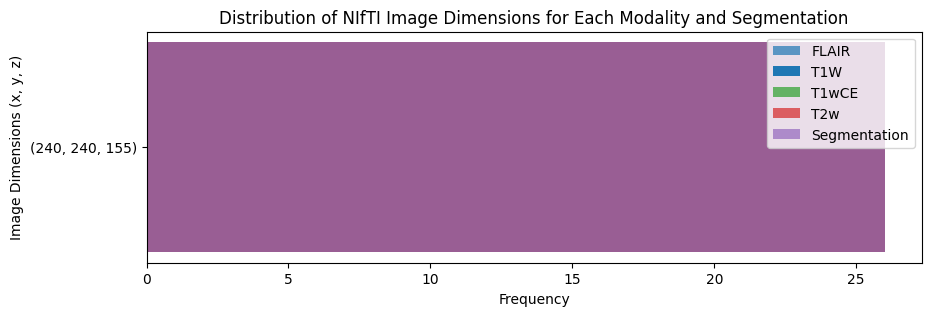

Statistics for FLAIR:
  X dimension - Min: 240, Max: 240, Mean: 240.00
  Y dimension - Min: 240, Max: 240, Mean: 240.00
  Z dimension - Min: 155, Max: 155, Mean: 155.00
-----------------------------------
Statistics for T1wCE:
  X dimension - Min: 240, Max: 240, Mean: 240.00
  Y dimension - Min: 240, Max: 240, Mean: 240.00
  Z dimension - Min: 155, Max: 155, Mean: 155.00
-----------------------------------
Statistics for T2w:
  X dimension - Min: 240, Max: 240, Mean: 240.00
  Y dimension - Min: 240, Max: 240, Mean: 240.00
  Z dimension - Min: 155, Max: 155, Mean: 155.00
-----------------------------------
Statistics for Segmentation:
  X dimension - Min: 240, Max: 240, Mean: 240.00
  Y dimension - Min: 240, Max: 240, Mean: 240.00
  Z dimension - Min: 155, Max: 155, Mean: 155.00
-----------------------------------


In [18]:
# Plot distribution of image dimensions for specific site
dimensions = get_nifti_dimensions(IvyGAP_site, substring='_resampled.nii.gz')
plot_dimension_distribution(dimensions, figsize=(10, 3))

# Print dimension statistics
print_dimension_statistics(dimensions)

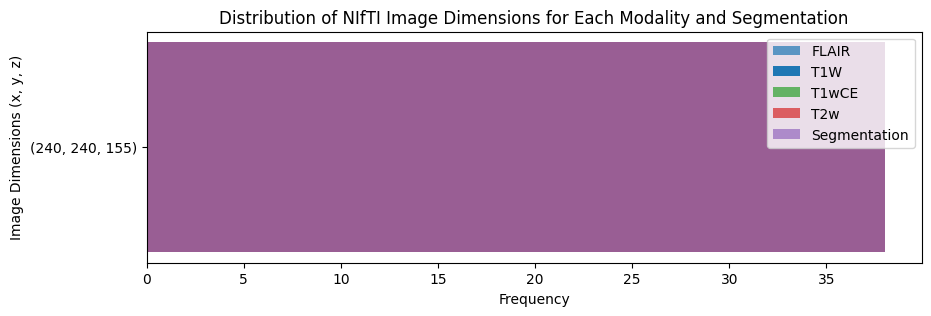

Statistics for FLAIR:
  X dimension - Min: 240, Max: 240, Mean: 240.00
  Y dimension - Min: 240, Max: 240, Mean: 240.00
  Z dimension - Min: 155, Max: 155, Mean: 155.00
-----------------------------------
Statistics for T1wCE:
  X dimension - Min: 240, Max: 240, Mean: 240.00
  Y dimension - Min: 240, Max: 240, Mean: 240.00
  Z dimension - Min: 155, Max: 155, Mean: 155.00
-----------------------------------
Statistics for T2w:
  X dimension - Min: 240, Max: 240, Mean: 240.00
  Y dimension - Min: 240, Max: 240, Mean: 240.00
  Z dimension - Min: 155, Max: 155, Mean: 155.00
-----------------------------------
Statistics for Segmentation:
  X dimension - Min: 240, Max: 240, Mean: 240.00
  Y dimension - Min: 240, Max: 240, Mean: 240.00
  Z dimension - Min: 155, Max: 155, Mean: 155.00
-----------------------------------


In [19]:
# Plot distribution of image dimensions for specific site
dimensions = get_nifti_dimensions(new_not_previously_in_TCIA_site, substring='_resampled.nii.gz')
plot_dimension_distribution(dimensions, figsize=(10, 3))

# Print dimension statistics
print_dimension_statistics(dimensions)

Finally, let's move all images (along with their metadata) to a centralized `TRAINING DATA` directory

In [52]:
from pathlib import Path

root_nifti = Path(PROCESSED_DATA_DIR) / 'NIfTI'
training_dir = Path(PROCESSED_DATA_DIR) / 'training_data'

# Iterate over sites using os.scandir() for faster directory access
for site_entry in os.scandir(root_nifti):
    if not site_entry.is_dir():
        continue
    
    site = site_entry.name
    site_path = Path(site_entry.path)

    # Iterate over subjects
    for sub_entry in os.scandir(site_path):
        if not sub_entry.is_dir():
            continue
        
        # Parse subject path
        sub = sub_entry.name
        sub_path = Path(sub_entry.path)

        # Resample all exams for the subject
        for exam in ['FLAIR', 'T1w', 'T2w', 'T1wCE']:
            exam_path = sub_path / exam / f"{site}_{sub}_{exam}_resampled.nii.gz"
            # Some exams might not exist
            if not os.path.exists(exam_path):
                continue
            
            # Define the output filename
            new_file_name = f"{site}_{sub}_{exam}.nii.gz"
            destination_dir = training_dir / f'BraTS2021_{site}_{sub}' 
            os.makedirs(destination_dir, exist_ok=True)

            # Resample image        
            destination_path = destination_dir / f'BraTS2021_{site}_{sub}_{exam.lower()}.nii.gz'
            shutil.copy(exam_path, destination_path)    
            
        # Copy segmentation for the given subject
        seg_path = sub_path / f"{site}_{sub}_segmentation.nii.gz"    
        destination_path = destination_dir / f"BraTS2021_{site}_{sub}_seg.nii.gz"
        shutil.copy(seg_path, destination_path)        